In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 'broad_blueprint'

# make sure the orders of the two list match
CELLTYPES = ['Blueprint-T', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
ABRIDGED_NAMES = ['T', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name
TITRATING_CELLTYPE = 'Blueprint-B'
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 

TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
# TITRATION_LIST=[0.2, 0.15]

# proportion of cells in real whole blood (sum to 1)
WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
                         'Blueprint-Mono':0.09,
                         'Blueprint-Neutro':0.57,
                         'Blueprint-T':0.23,
                         'Blueprint-NK':0.05}
    

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]

[0.2,
 0.19574468085106386,
 0.04255319148936171,
 0.07659574468085106,
 0.4851063829787234]

In [5]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [6]:
#########################################
#  Deconvolution Parameters and paths   # 
#########################################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.t_combined.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.t_combined.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [7]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(280, 9)

In [8]:
%%time

CELLTYPES = ['Blueprint-B',
             'Blueprint-T',
            'Blueprint-NK',
            'Blueprint-Mono',
            'Blueprint-Neutro']

# load score data from all cell types
deconvolution_nnls = []

# TITRATION_LIST = teff_titrating_proprotions
SCORE_VAR = 'frac_alpha_leq_25pct'
FILTER_COV = 20

for celltype in CELLTYPES: 
    EXPERIMENT_NAME = f'{celltype}-{BACKGROUND}/'            # <-- iterate over this
    EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
    SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'

    # iterate nnls deconvolition on each score_df
    deconv_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)
    
    deconvolution_nnls.append(deconv_nnls)

CPU times: user 8.46 s, sys: 79.5 ms, total: 8.54 s
Wall time: 8.58 s


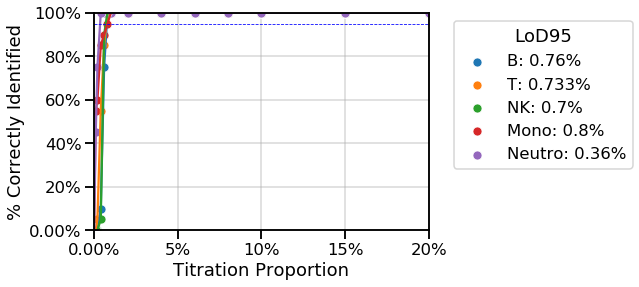

In [9]:
import pickle

outdir = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/broad_blueprint/plot_files/blueprint_lod_greater_than_threshold.pickle'

outdict = {
    'names':['B', 'T', 'NK', 'Mono', 'Neutro'],
    'titrating_celltypes': ['immune_b', 'immune_t', 'immune_nk', 'immune_dend_plus_macro_plus_mono', 'immune_neutro'], 
    'titrating_celltype_proportion': TITRATION_LIST, 
    'deconvolution_nnls': deconvolution_nnls,
    'xlim':0.2,
    'detection_threshold':0.005, 
    'lod':0.95
}

with open(outdir, 'wb') as handle:
    pickle.dump(outdict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(outdir, 'rb') as handle:
    plot_dict = pickle.load(handle)

sns.set_context('talk')
dcnv.lod95_detect_plot(names=plot_dict['names'],
                  titrating_celltypes = plot_dict['titrating_celltypes'], 
                  titrating_celltype_proportion = plot_dict['titrating_celltype_proportion'], 
                  deconvolution_preds = plot_dict['deconvolution_nnls'],
                  xlim=plot_dict['xlim'],
                  detection_threshold = plot_dict['detection_threshold'], 
                  lod=plot_dict['lod'])

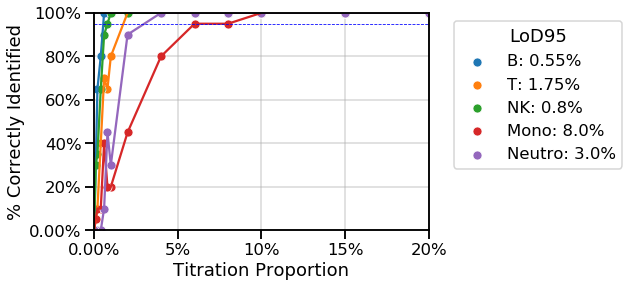

In [10]:
import pickle

outdir = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/broad_blueprint/plot_files/blueprint_lod_within_30p.pickle'

outdict = {
    'names':['B', 'T', 'NK', 'Mono', 'Neutro'],
    'titrating_celltypes': ['immune_b', 'immune_t', 'immune_nk', 'immune_dend_plus_macro_plus_mono', 'immune_neutro'], 
    'titrating_celltype_proportion': TITRATION_LIST, 
    'deconvolution_nnls': deconvolution_nnls,
    'xlim':0.2,
    'tolerance':0.3, 
    'lod':0.95
}

with open(outdir, 'wb') as handle:
    pickle.dump(outdict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(outdir, 'rb') as handle:
    plot_dict = pickle.load(handle)

sns.set_context('talk')
dcnv.lod95_within_proportion_plot(names=plot_dict['names'],
                  titrating_celltypes = plot_dict['titrating_celltypes'], 
                  titrating_celltype_proportion = plot_dict['titrating_celltype_proportion'], 
                  deconvolution_preds = plot_dict['deconvolution_nnls'],
                  xlim=plot_dict['xlim'],
                  tolerance = plot_dict['tolerance'], 
                  lod=plot_dict['lod'])

In [15]:
# sns.set_context('talk')
# dcnv.lod95_detect_plot(names=['B', 'T', 'NK', 'Mono', 'Neutro'],
#                   titrating_celltypes = ['immune_b', 'immune_t', 'immune_nk', 'immune_dend_plus_macro_plus_mono', 'immune_neutro'], 
#                   titrating_celltype_proportion = TITRATION_LIST, 
#                   deconvolution_preds = deconvolution_nnls,
#                   xlim=0.2,
#                   detection_threshold = 0.005, 
#                   lod=0.95)

In [16]:
# dcnv.lod95_within_proportion_plot(names=['B', 'T', 'NK', 'Mono', 'Neutro'],
#                   titrating_celltypes = ['immune_b', 'immune_t', 'immune_nk', 'immune_dend_plus_macro_plus_mono', 'immune_neutro'], 
#                               titrating_celltype_proportion = TITRATION_LIST, 
#                               deconvolution_preds = deconvolution_nnls, 
#                               xlim=0.2,
#                               tolerance = 0.3, 
#                               lod=0.95)